<a href="https://colab.research.google.com/github/sayakpaul/Image-Adversaries-101/blob/master/Image_Adversaries_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Contents of this notebook come from: https://adversarial-ml-tutorial.org/introduction/.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc2


In [0]:
!wget https://adversarial-ml-tutorial.org/introduction/pig.jpg

In [0]:
import matplotlib.pyplot as plt

def show_image(image_path):
    image_pixels = plt.imread(image_path)
    plt.imshow(image_pixels)
    plt.show()
    return image_pixels

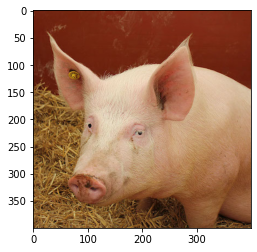

In [4]:
sample_image = show_image("pig.jpg")

In [0]:
# Load ResNet50
resnet50 = tf.keras.applications.ResNet50(weights="imagenet")

In [0]:
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import cv2

def preprocess_image(image_pixels):
    image_pixels = preprocess_input(image_pixels)
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, axis=0)

    return image_pixels

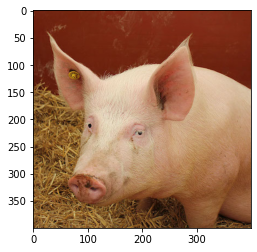

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02395406', 'hog', 0.99968374), ('n02396427', 'wild_boar', 0.00031595054), ('n03935335', 'piggy_bank', 9.8273716e-08)]


In [7]:
# Preprocess the image
sample_image = show_image("pig.jpg")
preprocessed_image = preprocess_image(sample_image)

# Run inference
preds = resnet50.predict(preprocessed_image)
print('Predicted:', tf.keras.applications.resnet50.decode_predictions(preds, top=3)[0])

In [8]:
# Class index
preds.argmax()

341

In [0]:
!wget https://raw.githubusercontent.com/USCDataScience/dl4j-kerasimport-examples/master/dl4j-import-example/data/imagenet_class_index.json

In [10]:
# Parse the label
import json

with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[preds.argmax()])

hog


In [11]:
# Loss has to be very low here
cce = tf.keras.losses.SparseCategoricalCrossentropy()
loss = cce(
    tf.convert_to_tensor([341]),
    tf.convert_to_tensor(preds)
)
print(loss.numpy())

0.0004157156


In [12]:
# The probability we got when we ran the inference
np.exp(-loss.numpy())

0.9995844

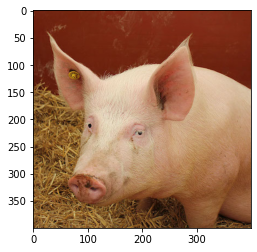

In [13]:
def preprocess_image_without(image_pixels):
    # image_pixels = preprocess_input(image_pixels)
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, axis=0)

    return image_pixels

# Load and preprocess image but a but without any `preprocess_input`
sample_image = show_image("pig.jpg")
preprocessed_image = preprocess_image_without(sample_image)

# Initialize the perturbation quantity
image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

In [0]:
# Clipping utility so that the pixel values stay within [0,1]
EPS = 2./255

def clip_eps(delta_tensor):
    return tf.clip_by_value(delta_tensor, clip_value_min=-EPS, clip_value_max=EPS)

In [0]:
# Let's create an adversarial example
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

In [16]:
# Generate Adversaries
scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()

for t in range(50):
    plt.show()
    with tf.GradientTape() as tape:
        tape.watch(delta)
        inp = preprocess_input(image_tensor + delta)
        predictions = resnet50(inp, training=False)
        loss = - scc_loss(
                tf.convert_to_tensor([341]),
                predictions
            )
        if t % 5 == 0:
            print(t, loss.numpy())
            # plt.imshow(50*delta.numpy().squeeze()+0.5)
        
    # Get the gradients
    gradients = tape.gradient(loss, delta)
    
    # Update the weights
    optimizer.apply_gradients([(gradients, delta)])

    # Clip so that the delta values are within [0,1]
    delta.assign_add(clip_eps(delta))

0 -0.00041083002
5 -0.0010640918
10 -0.005331109
15 -0.06319713
20 -0.7674426
25 -3.4517279
30 -7.455551
35 -13.31046
40 -16.118187
45 -16.11819


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


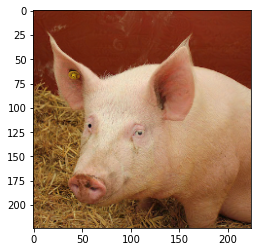

In [17]:
# See if the image changes
plt.imshow((image_tensor + delta).numpy().squeeze()/255)
plt.show()

In [18]:
# Generate prediction
perturbed_image = preprocess_input(image_tensor + delta)
preds = resnet50.predict(perturbed_image)
print('Predicted:', tf.keras.applications.resnet50.decode_predictions(preds, top=3)[0])

Predicted: [('n01883070', 'wombat', 0.9999833), ('n02909870', 'bucket', 9.77628e-06), ('n07930864', 'cup', 1.6957516e-06)]


The classifier generates wrong predictions even for slightest of perturbations. Let's put all of the above code together and create utility functions for quickly testing on new images. Note that in the above case, our class index was `341` for hog and to generlaize to other class (other than `hog`) of images we would need to supply the correct class indices to our method. 

In [0]:
def generate_adversaries(image_tensor, delta, true_class_index):
    # Loss and optimizer
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

    for t in range(50):
        plt.show()
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = preprocess_input(image_tensor + delta)
            predictions = resnet50(inp, training=False)
            loss = - scc_loss(
                    tf.convert_to_tensor([true_class_index]),
                    predictions
                )
            if t % 5 == 0:
                print(t, loss.numpy())
                # plt.imshow(50*delta.numpy().squeeze()+0.5)
            
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        # Clip so that the delta values are within [0,1]
        delta.assign_add(clip_eps(delta))

    return delta

In [0]:
def perturb_image(image_path, true_class_index):
    # Load and preprocess image but a but without any `preprocess_input`
    sample_image = show_image(image_path)
    preprocessed_image = preprocess_image_without(sample_image)

    # Generate predictions before any adversaries
    unsafe_preds = resnet50.predict(preprocess_input(preprocessed_image))
    print('Predicted before adv.:', tf.keras.applications.resnet50.decode_predictions(unsafe_preds, top=3)[0])

    # Initialize the perturbation quantity
    image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the adversary vector
    delta_tensor = generate_adversaries(image_tensor, delta, true_class_index)

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
    plt.show()

    # Generate prediction
    perturbed_image = preprocess_input(image_tensor + delta_tensor)
    preds = resnet50.predict(perturbed_image)
    print('Predicted:', tf.keras.applications.resnet50.decode_predictions(preds, top=3)[0])

In [0]:
# Image comes from https://www.flickr.com/photos/bambe1964/7837618434/
!wget https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/09/example.jpg

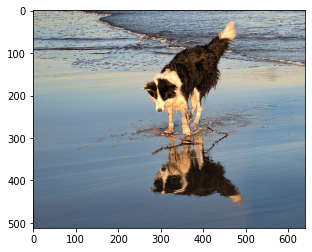

In [26]:
# Preview the image
plt.imshow(plt.imread("example.jpg"))
plt.show()

This fella is `Lakeland_terrier` and the class index in this case is `189`. Here's a handy little function to quickly find this out:

```python
for key, value in imagenet_classes.items():
    if imagenet_classes[key] == "Lakeland_terrier":
        print(key)
```

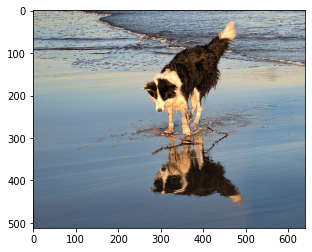

Predicted before adv.: [('n02095570', 'Lakeland_terrier', 0.3143305), ('n02102040', 'English_springer', 0.18979445), ('n02101388', 'Brittany_spaniel', 0.18742307)]
0 -1.1573795
5 -10.630953
10 -16.118187
15 -16.118189
20 -16.11819
25 -16.11819
30 -16.118193
35 -16.118193
40 -16.118193
45 -16.118193


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


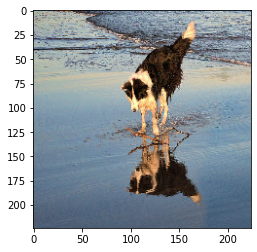

Predicted: [('n02102040', 'English_springer', 0.97474104), ('n02106166', 'Border_collie', 0.013487186), ('n02101388', 'Brittany_spaniel', 0.005806512)]


In [28]:
perturb_image("example.jpg", 189)

The method works here as well. Let's now tackle targeted attacks. 

In [0]:
def generate_adversaries_targeted(image_tensor, delta, 
    true_index, target_index):
    # Loss and optimizer
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)

    for t in range(350):
        plt.show()
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = preprocess_input(image_tensor + delta)
            predictions = resnet50(inp, training=False)
            loss = (- scc_loss(tf.convert_to_tensor([true_index]), predictions) + 
	                    scc_loss(tf.convert_to_tensor([target_index]), predictions))
            if t % 20 == 0:
                print(t, loss.numpy())
                # plt.imshow(50*delta.numpy().squeeze()+0.5)
            
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        # Clip so that the delta values are within [0,1]
        delta.assign_add(clip_eps(delta))

    return delta

In [0]:
def perturb_image(image_path, true, target):
    # Load and preprocess image but a but without any `preprocess_input`
    sample_image = show_image(image_path)
    preprocessed_image = preprocess_image_without(sample_image)

    # Generate predictions before any adversaries
    unsafe_preds = resnet50.predict(preprocess_input(preprocessed_image))
    print('Predicted before adv.:', tf.keras.applications.resnet50.decode_predictions(unsafe_preds, top=3)[0])

    # Initialize the perturbation quantity
    image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the adversary vector
    delta_tensor = generate_adversaries_targeted(image_tensor, delta, true, target)

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
    plt.show()

    # Generate prediction
    perturbed_image = preprocess_input(image_tensor + delta_tensor)
    preds = resnet50.predict(perturbed_image)
    print('Predicted:', tf.keras.applications.resnet50.decode_predictions(preds, top=3)[0])

Let's say we would want to perturbate the image of `hog` such that our classifier misclassifies it to be a `Lakeland_terrier`. Remember that the class index of `Lakeland_terrier` is `189` and the class index of `hog` is `341`.

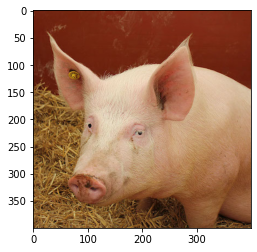

Predicted before adv.: [('n02395406', 'hog', 0.99968874), ('n02396427', 'wild_boar', 0.00031112912), ('n03935335', 'piggy_bank', 8.920516e-08)]
0 16.117785
20 16.115244
40 16.094202
60 13.4475765
80 9.2342205
100 6.4446225
120 4.544194
140 3.1463838
160 1.916471
180 0.8969135
200 0.00452137
220 -0.80513525
240 -1.5568495
260 -2.2489576
280 -2.8883865
300 -3.5479355
320 -4.1770263
340 -4.783001


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


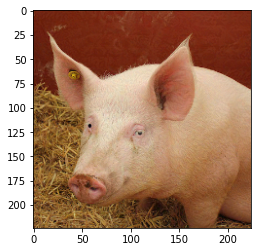

Predicted: [('n02095570', 'Lakeland_terrier', 0.07326998), ('n01883070', 'wombat', 0.037985403), ('n02098286', 'West_Highland_white_terrier', 0.034288753)]


In [33]:
# Let's see!
perturb_image("pig.jpg", 341, 189)

We are successful here as well. Let's see if we could do the same for the `Lakeland_terrier` image we saw earlier i.e. fool the classifier to believe that the image is of a hog.

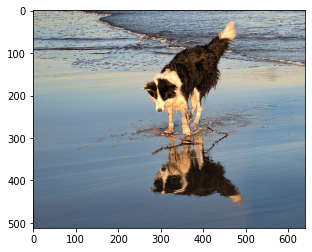

Predicted before adv.: [('n02095570', 'Lakeland_terrier', 0.3143305), ('n02102040', 'English_springer', 0.18979445), ('n02101388', 'Brittany_spaniel', 0.18742307)]
0 14.960787
20 9.918959
40 6.098837
60 3.2015429
80 0.856534
100 0.0
120 0.0
140 0.0
160 1.9073486e-06
180 0.0
200 0.0
220 0.0
240 0.0
260 0.0
280 0.0
300 0.0
320 0.0
340 0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


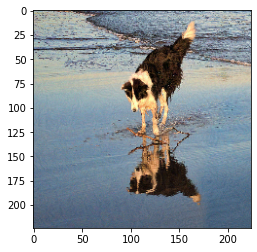

Predicted: [('n02102040', 'English_springer', 0.48360687), ('n02106166', 'Border_collie', 0.34620807), ('n02109525', 'Saint_Bernard', 0.07557377)]


In [34]:
perturb_image("example.jpg", 189, 341)

You see in this case, we could not get there but the classifier still yields wrong predicitions. May be we would need to train the system harder. Finally, let's see how our classifier does on an image constructed with random pixel values within `[0,255]` range. 

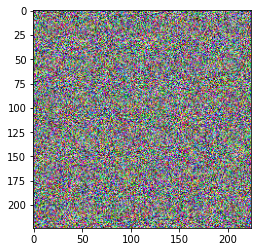

In [37]:
# Generate a random image and run predictions
random_image = np.random.uniform(low=0, high=255, size=(224,224,3)).astype("int")
plt.imshow(random_image)
plt.show()

Let's save it first so that we can reproduce it if we want to. 

In [47]:
# Serialize the random image
cv2.imwrite("random.png", random_image)

True

In [48]:
# Let's first see what our classifier thinks of this 
preprocessed_image = preprocess_image(plt.imread("random.png"))
preds = resnet50.predict(preprocessed_image)
print('Predicted:', tf.keras.applications.resnet50.decode_predictions(preds, top=3)[0])

Predicted: [('n06359193', 'web_site', 0.06508517), ('n03196217', 'digital_clock', 0.044688992), ('n01930112', 'nematode', 0.043546457)]


The classifier thinks it to be a `web_site`. Can we make it believe that it is a `hog`? Let's see!

In [49]:
# Let's get the class index for `tennis_ball` first
for key, value in imagenet_classes.items():
    if imagenet_classes[key] == "web_site":
        print(key)

916


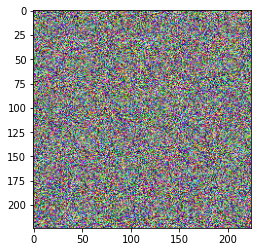

Predicted before adv.: [('n06359193', 'web_site', 0.06508517), ('n03196217', 'digital_clock', 0.044688992), ('n01930112', 'nematode', 0.043546457)]
0 7.1632943
20 6.5041842
40 6.1241045
60 5.731626
80 5.3543406
100 4.951699
120 4.5134706
140 4.0862756
160 3.6255307
180 3.0830097
200 2.5463924
220 2.1069345
240 1.7077804
260 1.3375049
280 0.97974634
300 0.599143
320 0.11381912
340 -0.3797531


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


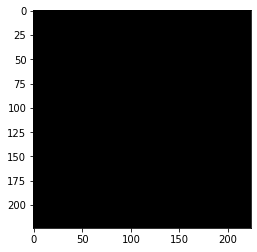

Predicted: [('n04590129', 'window_shade', 0.37725896), ('n04589890', 'window_screen', 0.05656971), ('n09229709', 'bubble', 0.036282938)]


In [50]:
# And ...
perturb_image("random.png", 916, 341)

A couple of observations here:
- When we tried to launch a targeted attack we failed at generating similar looking example and also failed at fooling the classifier to believe that it belong to the class of our choice. May be more rigorous training would have helped here (at least the losses tell so) but we are not sure since there is no structure in the pixels in the first place. 